In [1]:
# 기본 설치
# !pip install xgboost
# !pip install lightgbm
# !pip install missingno

# 데이터 세팅
# !wget https://aiffelstaticprd.blob.core.windows.net/media/documents/kaggle-kakr-housing-data.zip
# !unzip kaggle-kakr-housing-data.zip

In [2]:
# 라이브러리 요청
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 데이터 불러오기
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
# 데이터 곗수 확인
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
y = data['price']
del data['price']
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

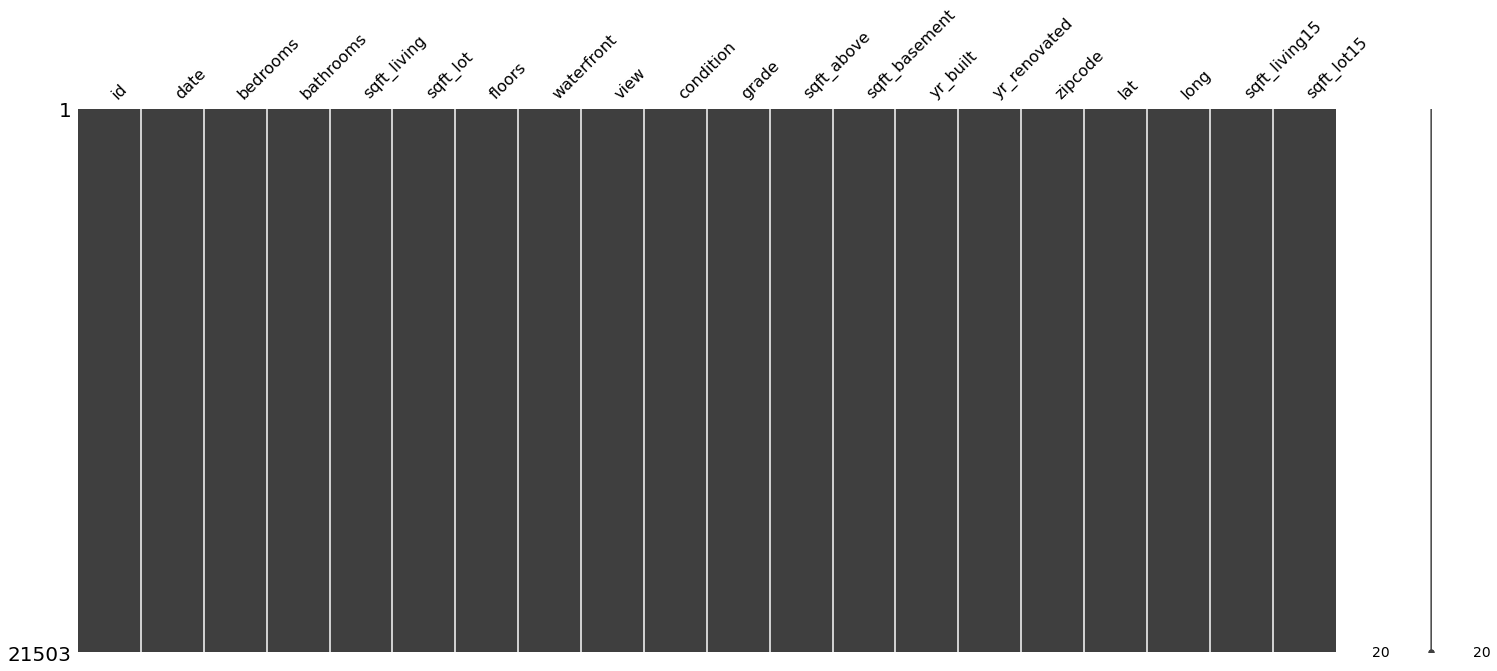

In [8]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [9]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [10]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [11]:
# 3. 결측치인 데이터의 개수를 셉니다.
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [12]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [13]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [14]:
data = data.apply(pd.to_numeric)

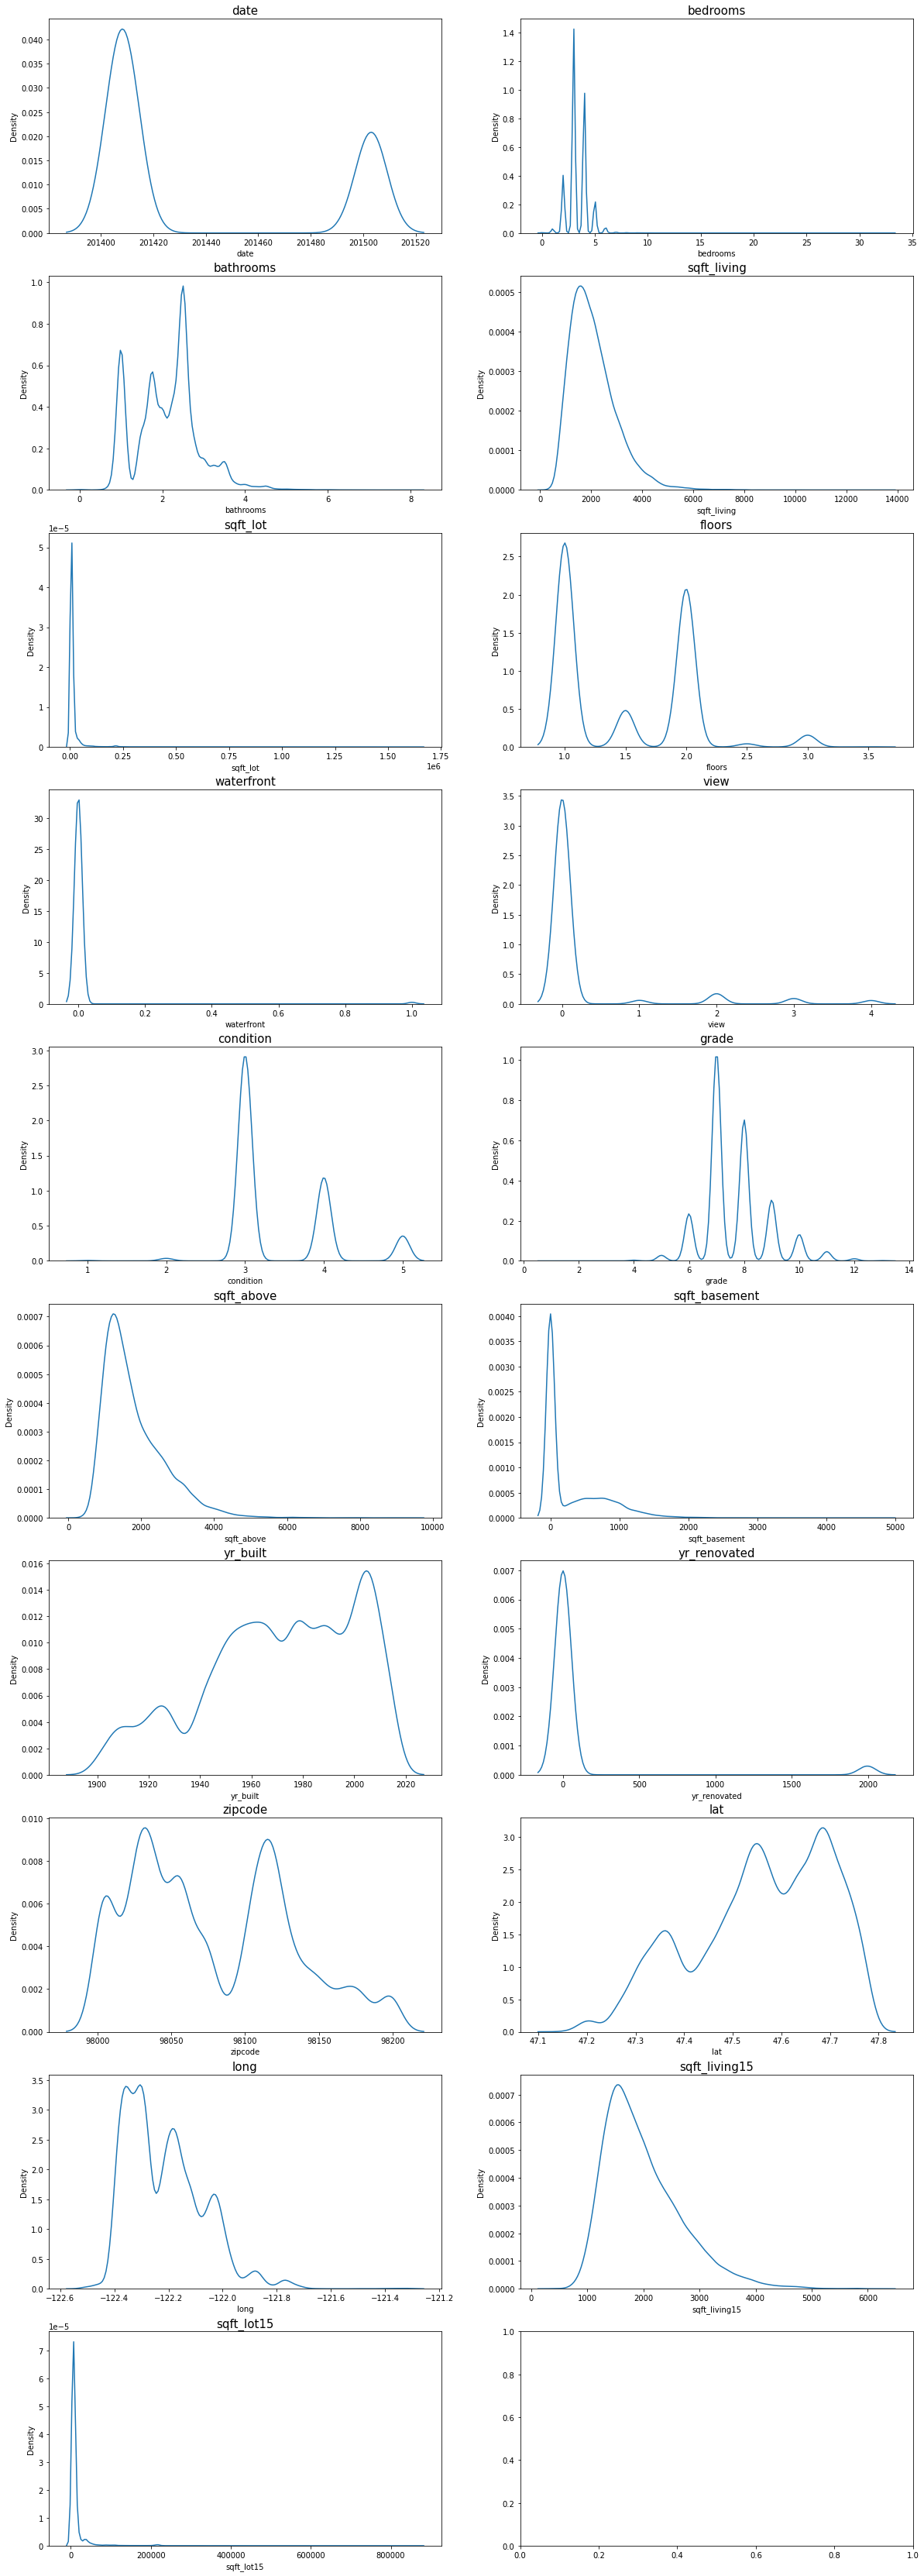

In [15]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data = data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [16]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)
data = data.apply(pd.to_numeric)

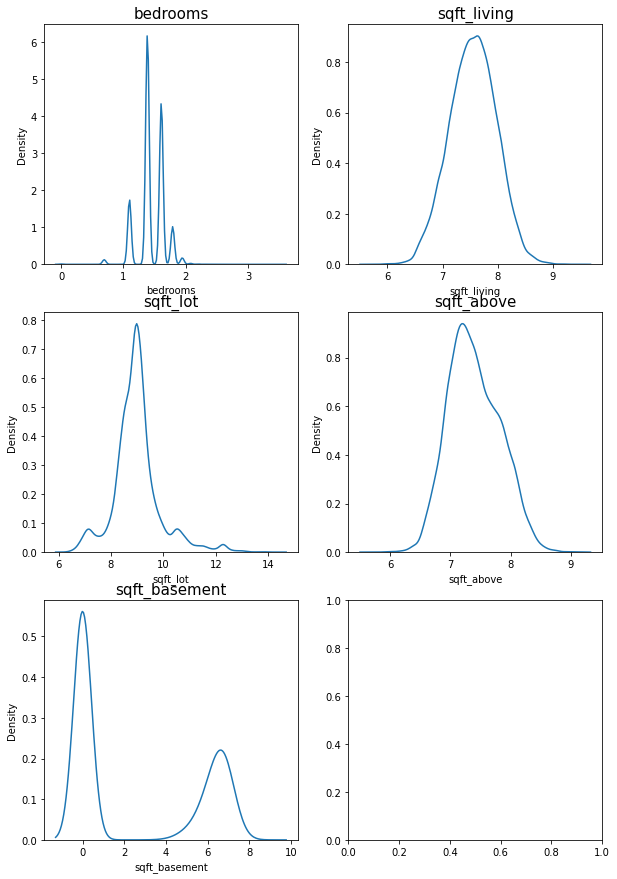

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data = data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [18]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [19]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [20]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), kf=kfold))

In [21]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [22]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [23]:
y_pred = AveragingBlending(models, x, y, sub)

In [24]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [25]:
sub.to_csv('data/submission.csv', index=False)

## 이때 나온 값을 사용하여 코드를 뽑고 제출함

In [26]:
data['lat_long'] = data.apply(lambda x : str(x.lat) + ', ' + str(x.long), axis = 1)

In [27]:
data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,lat_long
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650,"47.5112, -122.257"
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062,"47.7379, -122.233"
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503,"47.6168, -122.045"
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819,"47.3097, -122.327"
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711,"47.4095, -122.315"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,1320,11303,"47.3095, -122.002"
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,1400,1230,"47.5699, -122.288"
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,1330,1265,"47.5773, -122.409"
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,1020,2007,"47.5944, -122.299"
